## Part 4) Does an LLM perform better on 2007 or 2024 ?

In this part of the notebook we will use games played by **mistral 7B** and **llama3 8B** in 2007 and 2024 to compare the evolution of the LLM over time.

We used [ollama](https://ollama.com/) docker container version to used LLMs models (see `SETUP.md` for installations instructions). for the prompt used to generate the games, we used the following prompt (inspired by the prompt used [Human vs IA](https://drudilorenzo.github.io/ada-klech-data-story/)):

First we give the context of the game to the llm:

*We now play the following game:*

*I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it. Before starting, I give you one examples, then it's your turn:*

*you need to follow the same format as the example below:
Target word: George_Washington*

*Available options: [Able_Archer_83, Afghanistan, , Estonia, Europe, Finland, France, French_language, George_W._Bush, Hungary, September_11,_2001_attacks, United_States]*

*Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.*

*Answer: Hence the answer is: 'United_States'.*












Then we give the llm the target word and the list of options:

*I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it* 

*Target word: [{target}]*

*Available options: [{links}]*

*RESPECT THIS FORMAT WHEN ANSWERING:*

*Reasoning: [REASONING]*

*Answer: Hence the choice is: '[ANSWER]'*


We will repeat this prompt with the new available options until the llm finds the target word or the prompt reaches 100 iterations.

In [1]:
# Import librairies
import pandas as pd
from scipy.stats import ttest_ind

from src.utils.llm_plot import *
from src.utils.llm_metric import *
from src.utils.llm_processing import *

In [2]:
# Define consant
DATA = "data/"

Loading players games data on 2007 and LLMs (mistral, llama3) games data for 2007 and 2024

In [3]:
# Load data

## llama3 8B
llama3_2007 = pd.read_csv(DATA + "llama3/llm_paths.csv",index_col=['start', 'end'])
llama3_2024 = pd.read_csv(DATA + "llama3/llm_paths2024.csv",index_col=['start', 'end'])

## mistral 7B
mistral_2007 = pd.read_csv(DATA + "mistral/llm_paths.csv",index_col=['start', 'end'])
mistral_2024 = pd.read_csv(DATA + "mistral/llm_paths2024.csv",index_col=['start', 'end'])

## Player 2007
players_2007 = pd.read_csv(DATA + "wikispeedia_paths-and-graph/paths_finished.tsv",sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])

In [4]:
players_2007=process_player_path_data(players_2007)

### Compare LLMs with the players

**Warning** : At the moment we should be critical about the results, because the llms only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

The goal of this section is to compare the performance of the LLMs with the players in 2007 in order to see which LLMs seems to perform like the players in 2007.



Text(0.5, 1.0, 'Number of paths not found by model and year among 213 games')

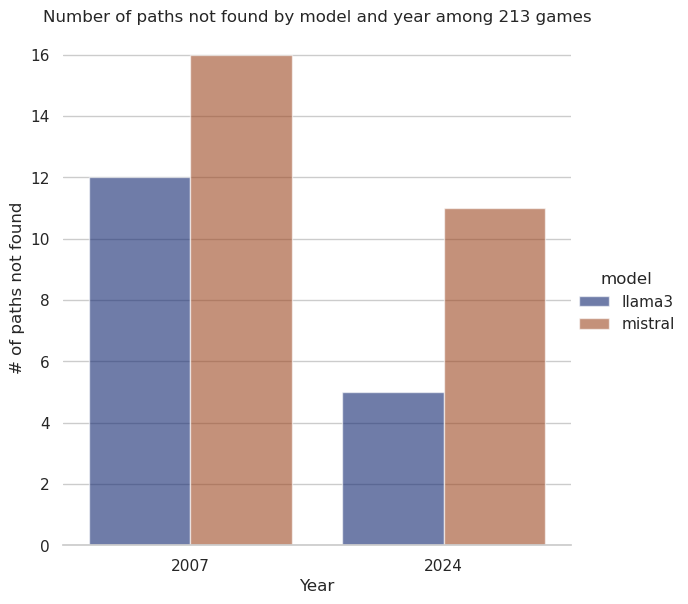

In [5]:
## count null paths for all model
llama3_2007_null = llama3_2007["path"].isnull().sum()
llama3_2024_null = llama3_2024["path"].isnull().sum()
mistral_2007_null = mistral_2007["path"].isnull().sum()
mistral_2024_null = mistral_2024["path"].isnull().sum()

null_paths = pd.DataFrame({ "model": ["llama3", "llama3", "mistral", "mistral"], "year": [2007, 2024, 2007, 2024], "null_paths": [llama3_2007_null, llama3_2024_null, mistral_2007_null, mistral_2024_null]})

sns.set_theme(style="whitegrid")
g = sns.catplot(x="year", y="null_paths", hue="model", data=null_paths, kind="bar", height=6, alpha=.6, palette="dark",errorbar="sd")
g.despine(left=True)
g.set_axis_labels("Year", "# of paths not found")
plt.title("Number of paths not found by model and year among 213 games")

On the bar plot above, we can observe that mistral struggled more to find paths than llama3 within 100 prompts. 

This result should be treated with coution because the LLMs only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

Data processing :

- Remove the games that the llms did not finish
- Process path given by the llms by removing periodic loops, consecutive duplicates, cut the list to the first occurence of the target word.
- Compute the length of the path
- Compute basic statistics on the length of the path for each llm and player

In [6]:
# drop null paths
llama3_2007 = llama3_2007.dropna()
llama3_2024 = llama3_2024.dropna()
mistral_2007 = mistral_2007.dropna()
mistral_2024 = mistral_2024.dropna()

# transform path str(list) to list
llama3_2007["path"] = llama3_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
llama3_2024["path"] = llama3_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2007["path"] = mistral_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2024["path"] = mistral_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))

In [7]:
# Post processing on paths 
llama3_2007["path"] = llama3_2007["path"].apply(post_processing)
llama3_2024["path"] = llama3_2024["path"].apply(post_processing)
mistral_2007["path"] = mistral_2007["path"].apply(post_processing)
mistral_2024["path"] = mistral_2024["path"].apply(post_processing)

In [8]:
llama3_2007["length"] = llama3_2007["path"].apply(len)
llama3_2024["length"] = llama3_2024["path"].apply(len)
mistral_2007["length"] = mistral_2007["path"].apply(len)
mistral_2024["length"] = mistral_2024["path"].apply(len)

In [9]:
# Compute the average length of the path for each model
avglen = pd.DataFrame(players_2007["length"].groupby(by=['start', 'end']).agg(['mean', 'std', 'median', 'count']))
avglen = pd.merge(avglen, llama3_2007['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llama3_2007'})
avglen = pd.merge(avglen, llama3_2024['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llama3_2024'})
avglen = pd.merge(avglen, mistral_2007['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'mistral_2007'})
avglen = pd.merge(avglen, mistral_2024['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'mistral_2024'})

In [10]:
avglen.reset_index(inplace=True)

In [11]:
generate_performance_scatter(avglen)

Llama3 seems to fall more often in the confidence interval of the players in 2007 than mistral. Let's see this in more detail below.

Number of LLM games in CI from player games: 66.66666666666666%
Number of Mistral games in CI from player games: 59.42028985507246%


Text(0.5, 1.0, 'Percentage of games in CI from player games')

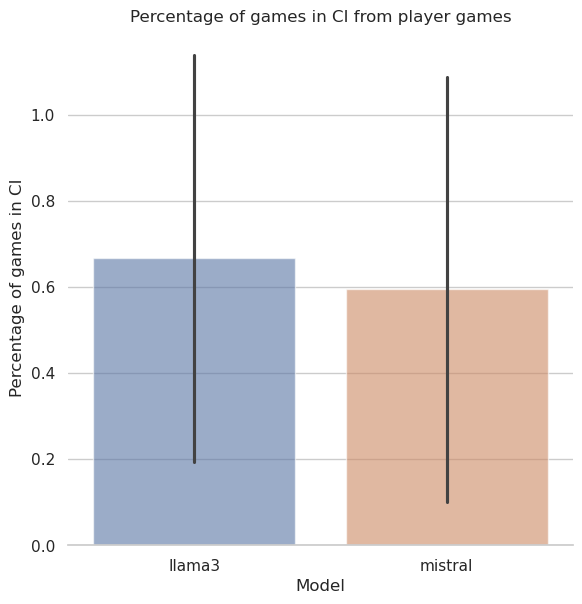

In [12]:
avglen['llama3_2007_in_CI'] = avglen.apply(lambda x: check_if_in_CI(x,'llama3_2007'), axis=1)
avglen["mistral_2007_in_CI"] = avglen.apply(lambda x: check_if_in_CI(x,'mistral_2007'), axis=1)
print(f'Number of LLM games in CI from player games: {avglen.llama3_2007_in_CI.mean()*100}%')
print(f'Number of Mistral games in CI from player games: {avglen.mistral_2007_in_CI.mean()*100}%')

# plot the number of games in CI
tmp_llama3 = avglen["llama3_2007_in_CI"].rename("in_CI").to_frame()
tmp_llama3["model"] = "llama3"
tmp_mistral = avglen["mistral_2007_in_CI"].rename("in_CI").to_frame()
tmp_mistral["model"] = "mistral"

ci_model = pd.concat([tmp_llama3, tmp_mistral])

sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="in_CI", hue="model", data=ci_model, kind="bar", height=6, alpha=.6,errorbar="sd")
g.despine(left=True)
g.set_axis_labels("Model", "Percentage of games in CI")
plt.title("Percentage of games in CI from player games")

Indeed, llama3 fall in 66.67% of the games in the confidence interval of the players in 2007, while mistral only fall in 59.42% of the games in the confidence interval of the players in 2007. 

But does llama3 take similar paths to the players in 2007 ? 

let's check that with the jaccard similarity of the article title in the next section.

This result should be treated with coution because the LLMs only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

Jaccard similarity between player and llama3 2007: 0.27016937576944144
Jaccard similarity between player and mistral 2007: 0.32329015886677054


Text(0.5, 1.0, 'Jaccard similarity between player and model')

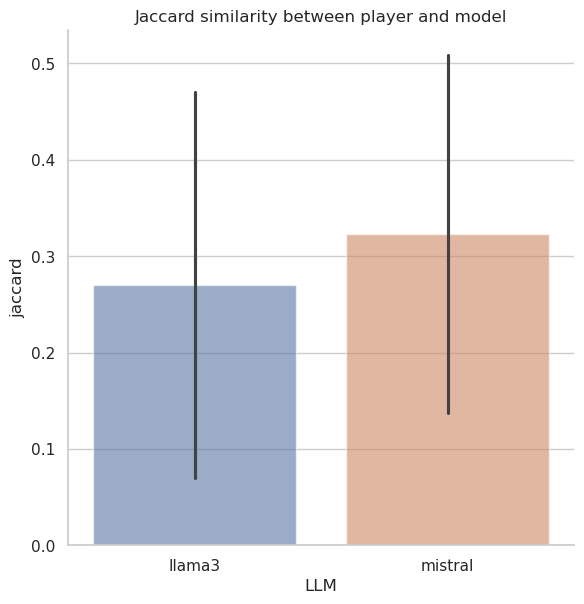

In [13]:
# compute jaccard similarity between player and model
players_2007 = players_2007["path"].apply(fix_path) # removing '<' in the path
jaccard_llama3 = pd.merge(players_2007, llama3_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_llama3['jaccard'] = jaccard_llama3.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and llama3 2007: {jaccard_llama3["jaccard"].mean()}')

jaccard_mistral = pd.merge(players_2007, mistral_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_mistral['jaccard'] = jaccard_mistral.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and mistral 2007: {jaccard_mistral["jaccard"].mean()}')

jaccard_llama3["LLM"] = "llama3"
jaccard_mistral["LLM"] = "mistral"

jaccard = pd.concat([jaccard_llama3, jaccard_mistral])
sns.set_theme(style="whitegrid")
g = sns.catplot(x="LLM", y="jaccard", hue="LLM", data=jaccard, kind="bar", height=6, alpha=.6,errorbar="sd")
plt.title("Jaccard similarity between player and model")

The jaccard similarity between the paths of the players in 2007 and llama3 is 0.27, which is quite low. This means that llama3 does not take similar paths to the players in 2007. the similarity with mistral is slightly higher with 0.32 but still low.

In [ ]:
# T-Test Compare the means of path lengths (human vs. model)
# with a significance level of 0.05
ttest_llama3 = ttest_ind(avglen['llama3_2007'], avglen['mean'])
ttest_mistral = ttest_ind(avglen['mistral_2007'], avglen['mean'])
print(f'T-Test between player and llama3 2007: {ttest_llama3}')
print(f'T-Test between player and mistral 2007: {ttest_mistral}')

T-Test between player and llama3 2007: TtestResult(statistic=1.1748021910869217, pvalue=0.24109380717803772, df=274.0)
T-Test between player and mistral 2007: TtestResult(statistic=3.2286406525332207, pvalue=0.0013952013335809983, df=274.0)


The level of significance is set to p=0.05 for the following T-Test.

The result of the T-Test between the paths length mean of the players in 2007 and llama3 is p-value = 0.2410. This means that we cannot reject the null hypothesis that the paths length mean of the players in 2007 and llama3 are equal.

the result of the T-Test between the paths length mean of the players in 2007 and mistral is p-value = 0.0014. This means that we can reject the null hypothesis that the paths length mean of the players in 2007 and mistral are equal.

### Compare the results of the LLMs on 2007 and 2024

Based on the previous results, we choose to compare the results of llama3 on 2007 and 2024.

**Warning** : At the moment we should be critical about the results, because the llms only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.



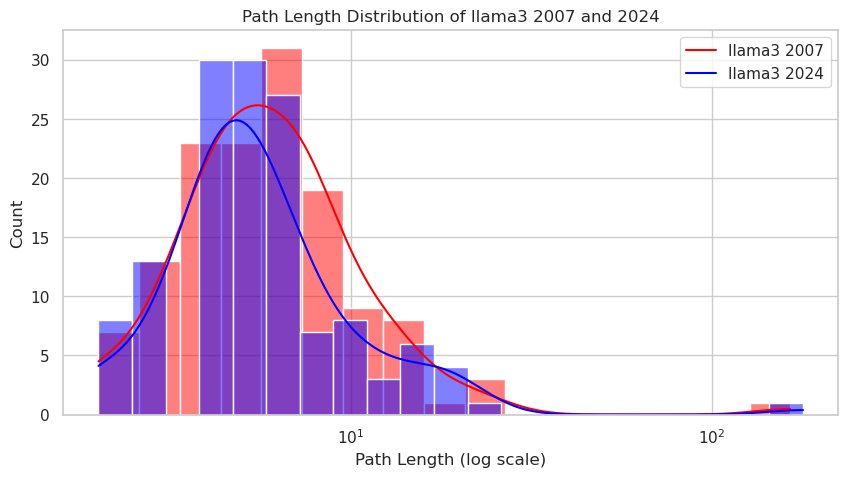

In [15]:
# plot path length distribution of llama3 2007 and 2024
plot_path_length_distribution(avglen, 'llama3',log_scale=True)

The graph above show a similar distribution of the paths length between 2007 and 2024 for llama3. This means that llama3 does not seem to have evolved between 2007 and 2024.

Further analysis will be done in the future once we have more played games to compare.